<h1 align = "center">TPS May 2022</h1>

---


**Objective:** The May edition of the 2022 Tabular Playground series binary classification problem that includes a number of different feature interactions. This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions ([competition](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/overview)). This notebook serves to provide codes that I've used for solving TPS May 2022. My initial plan is to use a powerful *neural network* to do a binary classification for *predicting states of manufacturing control data*.

## Code Imports

**PEP8 Style Guide** lists out the following [*guidelines*](https://peps.python.org/pep-0008/#imports) for imports:
 1. Imports should be on separate lines,
 2. Import order should be:
    * standard library/modules,
    * related third party imports,
    * local application/user defined imports
 3. Wildcard import (`*`) should be avoided, else specifically tagged with **`# noqa: F403`** as per `flake8` [(ignoring errors)](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html).
 4. Avoid using relative imports; use explicit imports instead.

In [1]:
import sys # append additional directories to list

In [2]:
from time import ctime # print computer time in human redable format
from os import makedirs # create directories dynamically
from os.path import join # joins mutiple path without os dependency
# from copy import deepcopy # make an actual copy of immutable objects like `str`
# from tqdm import tqdm as TQ # for displaying a nice progress bar while running
# from uuid import uuid1 as UUID # for generating unique identifier
from datetime import datetime as dt # formatting/defining datetime objects

[**`logging`**](https://docs.python.org/3/howto/logging.html) is a standard python module that is meant for tracking any events that happen during any software/code operations. This module is super powerful and helpful for code debugging and other purposes. The next section defines a `logging` configuration in **`../logs/`** directory. Modify the **`LOGS_DIR`** variable under *Global Arguments* to change the default directory. The module is configured with a simplistic approach, such that any `print())` statement can be update to `logging.LEVEL_NAME()` and the code will work. Use logging operations like:

```python
 >> logging.debug("This is a Debug Message.")
 >> logging.info("This is a Information Message.")
 >> logging.warning("This is a Warning Message.")
 >> logging.error("This is a ERROR Message.")
 >> logging.critical("This is a CRITICAL Message.")
```

Note: some directories related to logging is created by default. This can be updated/changed in the following configuration section.

In [3]:
import logging # configure logging on `global arguments` section, as file path is required

In [4]:
# import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style');
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
# np.set_printoptions(precision = 3, threshold = 15)
pd.options.display.float_format = '{:,.2f}'.format

### AI-ML Libraries

In this project, to build a neural network, I am using the **`TensorFlow`** module with GPU Compatibility.

In [5]:
import tensorflow as tf
print('Tensorflow Version: {}'.format(tf.__version__))

# check physical devices
tf.config.list_physical_devices()

Tensorflow Version: 2.6.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Global Argument(s)

The global arguments are *notebook* specific, however they may also be extended to external libraries and functions on import. The *boilerplate* provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.

In [6]:
ROOT = ".." # the document root is one level up, that contains all code structure
DATA = join(ROOT, "data") # the directory contains all data files, subdirectory (if any) can also be used/defined

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = join(DATA, "processed")

In [7]:
# long projects can be overwhelming, and keeping track of files, outputs and
# saved models can be intriguing! to help this out, `today` can be used. for
# instance output can be stored at `output/<today>/` etc.
# `today` is so configured that it permits windows/*.nix file/directory names
today = dt.strftime(dt.strptime(ctime(), "%a %b %d %H:%M:%S %Y"), "%a, %b %d %Y")
print(f"Code Execution Started on: {today}") # only date, name of the sub-directory

Code Execution Started on: Sun, May 08 2022


In [8]:
OUTPUT_DIR = join(ROOT, "output", today)
makedirs(OUTPUT_DIR, exist_ok = True) # create dir if not exist

# also create directory for `logs`
LOGS_DIR = join(ROOT, "logs", "TPS May 2022")
makedirs(LOGS_DIR, exist_ok = True)

In [9]:
print(LOGS_DIR) # logs file will be generated here

..\logs\TPS May 2022


In [10]:
logging.basicConfig(
    filename = join(LOGS_DIR, f"{today}.log"), # change `reports` file name
    filemode = "a", # append logs to existing file, if file exists
    format = "%(asctime)s - %(name)s - CLASS:%(levelname)s:%(levelno)s:L#%(lineno)d - %(message)s",
    level = logging.DEBUG
)

In [11]:
logging.info("Initializing Kernel, Global Arguments Configured....")
logging.info(f"Data Directory: {DATA}")
logging.info(f"Output Data Directory: {OUTPUT_DIR}")

## User Defined Function(s)

It is recommended that any UDFs are defined outside the scope of the *jupyter notebook* such that development/editing of function can be done more practically. As per *programming guidelines* as [`src`](https://fileinfo.com/extension/src) file/directory is beneficial in code development and/or production release. However, *jupyter notebook* requires *kernel restart* if any imported code file is changed in disc, for this frequently changing functions can be defined in this section.

**Getting Started** with **`PYTHONPATH`**

One must know what are [Environment Variable](https://medium.com/chingu/an-introduction-to-environment-variables-and-how-to-use-them-f602f66d15fa) and how to call/use them in your choice of programming language. Note that an environment variable is *case sensitive* in all operating systems (except windows, since DOS is not case sensitive). Generally, we can access environment variables from terminal/shell/command prompt as:

```shell
# macOS/*nix
echo $VARNAME

# windows
echo %VARNAME%
```

Once you've setup your system with [`PYTHONPATH`](https://bic-berkeley.github.io/psych-214-fall-2016/using_pythonpath.html) as per [*python documentation*](https://docs.python.org/3/using/cmdline.html#envvar-PYTHONPATH) is an important directory where any `import` statements looks for based on their order of importance. If a source code/module is not available check necessary environment variables and/or ask the administrator for the source files.

For testing purpose, the module boasts the use of `src`, `utils` and `config` directories. However, these directories are available at `ROOT` level, and thus using `sys.path.append()` to add directories while importing.

In [12]:
sys.path.append(join(ROOT, "src")) # source files
sys.path.append(join(ROOT, "src", "agents")) # agents for an efficient rl model
sys.path.append(join(ROOT, "src", "engine")) # ai/ml code engines for modelling
sys.path.append(join(ROOT, "src", "models")) # defination of actual ai/ml model
sys.path.append(join(ROOT, "utilities")) # provide a list of utility functions

In [13]:
from dfutils import reduce_mem_usage
from visualizations import corr_heatmap

In [14]:
def read_file(filepath : str, reduce_memory : bool = True) -> pd.DataFrame:
    data = pd.read_csv(filepath) # read csv file as is
    
    # do some pre-processing on the data-frame
    data.set_index("id", inplace = True) # set index
    data.drop(columns = ["f_27"], inplace = True) # drop object feature
    
    if reduce_memory:
        data = reduce_mem_usage(data, subset = None, copy = False)
    
    return data.copy() # deepcopy

## Read Input File(s)

A typical machine learning project revolves around six important stages (as available in [Amazon ML Life Cycle Documentation](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/well-architected-machine-learning-lifecycle.html)). The notebook boilerplate is provided to address two pillars:

 1. **Data Processing:** An integral part of any machine learning project, which is the most time consuming step! A brief introduction and best practices is available [here](https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d).
 2. **Model Development:** From understanding to deployment, this section address development (training, validating and testing) of an machine learning model.

![ML Life Cycle](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/images/ml-lifecycle.png)

In [15]:
trn_data = read_file(join(DATA, "train.csv"), reduce_memory = False)
tst_data = read_file(join(DATA, "test.csv"), reduce_memory = False)

### Basic Data Information

Training and testing data is read into two variables `trn_data` and `tst_data` respectively. Let's use the basic `pandas` functionalities to find information about the data. The target is a binary column and marked as `target`, and the data has a total of 31 features marked as `f_00, f_01, ..., f_30`. Among the given feature `f_27` is some object data which is simply ignored in `read_file()` function. Also, `id` column is set as index for both training and testing set, and we will require the IDs when submitting the result.

In [16]:
trn_data.sample(5)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
403900,1.70,0.52,0.11,0.70,-1.04,0.48,-2.29,4,3,5,1,0,8,1,4,3,5,1,2,0.62,-3.33,2.82,-4.77,-4.14,-1.87,0.31,0.34,175.50,1,2,0
141698,1.21,0.44,1.47,-0.98,-0.32,-0.98,-0.59,1,2,3,4,1,0,3,0,4,0,1,1,4.08,-2.38,-0.54,-2.90,-0.26,-1.20,-1.52,-1.61,87.94,0,1,0
365948,-0.54,-1.13,2.83,1.71,0.82,0.88,-0.79,3,3,0,0,2,1,1,1,1,5,3,1,0.41,-0.79,0.48,-2.69,2.19,1.47,2.34,1.36,473.50,0,1,0
204430,-1.39,0.75,-1.31,1.28,0.05,-0.43,0.75,1,1,2,2,1,3,4,0,3,1,1,0,-1.37,-0.86,4.35,-0.58,2.32,2.29,-0.94,-0.55,-284.75,1,1,1
695186,-1.39,0.63,-1.25,-0.54,0.01,-1.59,0.29,0,2,1,3,2,2,0,5,1,3,0,4,1.35,-2.91,-5.34,4.21,-3.92,0.09,1.62,-5.99,-378.25,1,2,0


In [15]:
trn_data.shape

(900000, 31)

In [18]:
trn_data.describe(percentiles = [0.05, 0.25, 0.50, 0.75, 0.95])

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,"900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00","900,000.00"
mean,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,2.03,2.06,2.36,2.18,1.80,2.84,2.24,1.51,2.10,2.10,1.86,2.07,0.31,-0.18,-0.16,-0.01,-0.37,-0.34,0.18,0.36,-0.38,0.35,1.00,0.49
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.66,1.59,1.64,1.65,1.54,1.76,1.54,1.36,1.57,1.56,1.47,1.56,2.32,2.40,2.48,2.45,2.45,2.39,2.42,2.48,238.77,0.48,0.82,0.50
min,-4.60,-4.68,-4.64,-4.66,-4.75,-4.75,-4.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-11.28,-11.26,-13.31,-11.85,-12.30,-11.42,-11.92,-14.30,"-1,229.75",0.00,0.00,0.00
5%,-1.64,-1.64,-1.65,-1.65,-1.64,-1.64,-1.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.53,-4.11,-4.24,-4.11,-4.36,-4.26,-3.77,-3.78,-392.09,0.00,0.00,0.00
25%,-0.68,-0.68,-0.67,-0.68,-0.68,-0.67,-0.67,1.00,1.00,1.00,1.00,1.00,2.00,1.00,0.00,1.00,1.00,1.00,1.00,-1.24,-1.80,-1.82,-1.65,-2.02,-1.96,-1.44,-1.26,-159.43,0.00,0.00,0.00
50%,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,2.00,2.00,2.00,2.00,2.00,3.00,2.00,1.00,2.00,2.00,2.00,2.00,0.33,-0.19,-0.15,0.03,-0.39,-0.34,0.16,0.40,-0.52,0.00,1.00,0.00
75%,0.67,0.68,0.68,0.67,0.67,0.68,0.67,3.00,3.00,3.00,3.00,3.00,4.00,3.00,2.00,3.00,3.00,3.00,3.00,1.88,1.44,1.51,1.66,1.26,1.27,1.80,2.03,158.99,1.00,2.00,1.00
95%,1.64,1.65,1.65,1.64,1.65,1.65,1.65,5.00,5.00,5.00,5.00,5.00,6.00,5.00,4.00,5.00,5.00,5.00,5.00,4.08,3.78,3.91,3.95,3.71,3.58,4.16,4.34,392.65,1.00,2.00,1.00
max,4.75,4.82,4.96,4.45,4.95,4.97,4.82,15.00,16.00,14.00,14.00,13.00,16.00,12.00,14.00,14.00,15.00,14.00,13.00,12.08,11.48,14.46,11.34,12.25,12.39,12.53,12.91,"1,229.56",1.00,2.00,1.00


**About the Data:** There are 0.9 millions records, and there are no NaN/null values. This can also be verified using: `trn_data.isnull().sum().sum()`. Now, on checking the number of unique values, we can separate the *categorical* variables as below.

In [24]:
trn_data.nunique().sort_values(ascending = True) # check unique value count

target         2
f_29           2
f_30           3
f_13          13
f_18          14
f_17          14
f_14          14
f_11          14
f_10          15
f_15          15
f_09          15
f_08          16
f_07          16
f_12          16
f_16          16
f_01      900000
f_28      900000
f_26      900000
f_25      900000
f_24      900000
f_23      900000
f_22      900000
f_20      900000
f_19      900000
f_02      900000
f_03      900000
f_04      900000
f_05      900000
f_06      900000
f_21      900000
f_00      900000
dtype: int64

In [35]:
trn_data.nunique().where(lambda x : x <= 16).dropna().index # maybe do featuring

Index(['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15',
       'f_16', 'f_17', 'f_18', 'f_29', 'f_30', 'target'],
      dtype='object')

### Correlation \& Features Selection

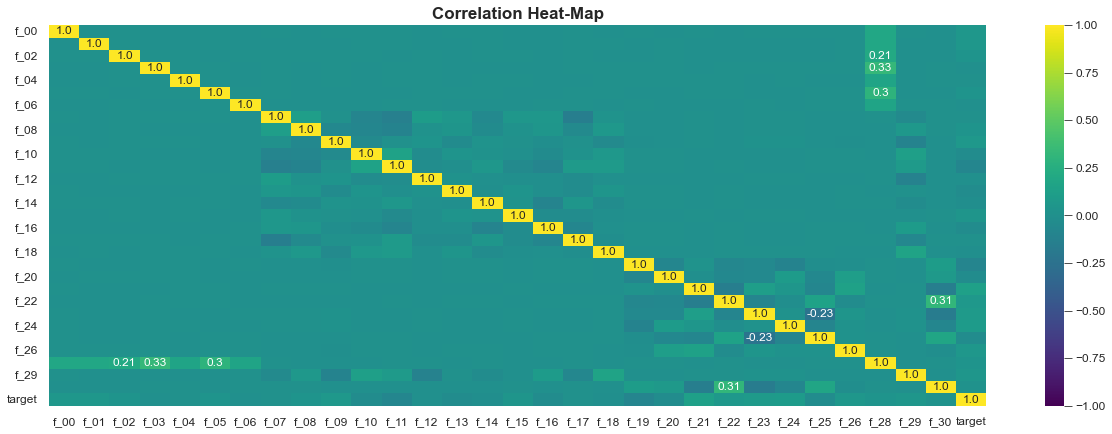

In [15]:
corr_heatmap(trn_data, annot_threshold = 0.2)

plt.title("Correlation Heat-Map")
plt.show()

## Deep Learning Application

In [31]:
x = trn_data.drop(columns = "target").values
y = trn_data["target"].values

In [51]:
INPUT_SHAPE = x.shape[1]
OUTPUT_SHAPE = len(set(y))

INPUT_SHAPE, OUTPUT_SHAPE

(30, 2)

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape = (INPUT_SHAPE, ), activation = "swish", name = "iLayer"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = "swish"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = "swish"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "swish"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(OUTPUT_SHAPE, activation = "sigmoid", name = "oLayer"),
], name = "DFC-1.0.0")

model.summary(line_length = 127)

Model: "DFC-1.0.0"
_______________________________________________________________________________________________________________________________
Layer (type)                                             Output Shape                                      Param #             
iLayer (Dense)                                           (None, 64)                                        1984                
_______________________________________________________________________________________________________________________________
dropout_12 (Dropout)                                     (None, 64)                                        0                   
_______________________________________________________________________________________________________________________________
dense_12 (Dense)                                         (None, 128)                                       8320                
_____________________________________________________________________________________

In [53]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [54]:
history = model.fit(x, y, epochs = 10, batch_size = 128)

Epoch 1/10


C:\Anaconda3\envs\TensorFlow\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


7032/7032 [==============================] - 14s 2ms/step - loss: 0.5577 - sparse_categorical_accuracy: 0.7051
Epoch 2/10
7032/7032 [==============================] - 14s 2ms/step - loss: 0.4472 - sparse_categorical_accuracy: 0.7971
Epoch 3/10
7032/7032 [==============================] - 13s 2ms/step - loss: 0.4139 - sparse_categorical_accuracy: 0.8185
Epoch 4/10
7032/7032 [==============================] - 13s 2ms/step - loss: 0.4006 - sparse_categorical_accuracy: 0.8273
Epoch 5/10
7032/7032 [==============================] - 14s 2ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.8328
Epoch 6/10
7032/7032 [==============================] - 14s 2ms/step - loss: 0.3847 - sparse_categorical_accuracy: 0.8371
Epoch 7/10
7032/7032 [==============================] - 14s 2ms/step - loss: 0.3792 - sparse_categorical_accuracy: 0.8401
Epoch 8/10
7032/7032 [==============================] - 15s 2ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8422
Epoch 9/10
7032/7032 [=============

In [57]:
yPredicted = model.predict(tst_data.values)

In [58]:
yPredicted

array([[0.128, 0.574],
       [0.192, 0.726],
       [0.969, 0.095],
       ...,
       [0.692, 0.399],
       [0.772, 0.216],
       [0.866, 0.217]], dtype=float32)

In [69]:
output = pd.DataFrame({"id" : tst_data.index, "target" : np.argmax(yPredicted, axis = 1)})
output.to_csv(join(OUTPUT_DIR, "DFC100-08052022.csv"), index = False)